In [48]:
# ============================================================
# Adapter: run M-GW on SpatialMETA Y7 ST & SM .h5ad files
# ============================================================
import anndata as ad
import numpy as np, torch, scipy.sparse as sp
from mgw import plotting, models, geometry
from mgw import pullback_metric_field, knn_graph
import importlib; importlib.reload(geometry)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(torch.float64)
print("Device:", device)

# ----------------------------
# Config
# ----------------------------
st_path = "/scratch/gpfs/ph3641/mgw/adata_ST_Y7_T_raw.h5ad"
sm_path = "/scratch/gpfs/ph3641/mgw/adata_SM_Y7_T_raw.h5ad"

# Which layer to use for features; set to None to use .X
ST_LAYER = None
SM_LAYER = None

# Preprocessing
log1p_features = True
zscore_per_feature = True
n_features_st = 256   # set None to keep all
n_features_sm = 256   # set None to keep all

# Graph / geodesic params
knn_k = 12
geodesic_eps = 1e-6   # used inside pullback metric calc


Device: cuda


In [49]:
from mgw import util

results = util.project_informative_features(st_path, sm_path, PCA_comp=30, CCA_comp=3, spatial_only=True, feature_only=False)


/home/ph3641/ManifoldAlignment/mgw/util.py:180: UserWarning: Ignoring svd_solver='auto' and using randomized, sklearn.decomposition._truncated_svd.TruncatedSVD only supports dict_keys(['arpack', 'randomized']).
  sc.tl.pca(


PCA shapes -> X: (2018, 30) Z: (10649, 30)
Feeler GW sizes: X-side 2018, Z-side 8000
Solving feeler feature alignment.
[OTT] GW  ε=1.00e-03  iters=-1  loss≈2.0724e-03
Computing CCA Components
CCA dims: 3  (applied to full sets)


In [51]:
import scanpy as sc
import scipy.sparse as sp
importlib.reload(util)

# --- Project features
pca=False

xs, xs2 = results["xs"], results["xt"]
if pca:
    ys, ys2 = results["X_pca"], results["Z_pca"]
else:
    ys, ys2 = results["X_cca_full"], results["Z_cca_full"]

xs_t  = torch.from_numpy(xs).to(device)
xs2_t = torch.from_numpy(xs2).to(device)

ys_t  = util.normalize_range(torch.from_numpy(ys).to(device))
ys2_t = util.normalize_range(torch.from_numpy(ys2).to(device))

dim_e   = 2
dim_f_M = ys_t.shape[1]
dim_f_N = ys2_t.shape[1]
print("dims:", dim_e, dim_f_M, dim_f_N)


dims: 2 3 3


In [52]:

# ----------------------------
# Learn φ, ψ : (coords)->(features)
# ----------------------------
phi = models.PhiModel(dim_e, dim_f_M, widths=(128,256,256,128)).to(device)
psi = models.PhiModel(dim_e, dim_f_N, widths=(128,256,256,128)).to(device)

phi = models.train_phi(phi, xs_t, ys_t, lr=1e-3, niter=10000, print_every=500, device=device)
psi = models.train_phi(psi, xs2_t, ys2_t, lr=1e-3, niter=10000, print_every=500, device=device)
phi.eval(); psi.eval()


[train_phi] step=500 loss=0.229814
[train_phi] step=1000 loss=0.186247
[train_phi] step=1500 loss=0.184497
[train_phi] step=2000 loss=0.156682
[train_phi] step=2500 loss=0.160644
[train_phi] step=3000 loss=0.145018
[train_phi] step=3500 loss=0.143522
[train_phi] step=4000 loss=0.141354
[train_phi] step=4500 loss=0.133470
[train_phi] step=5000 loss=0.130823
[train_phi] step=5500 loss=0.145307
[train_phi] step=6000 loss=0.124607
[train_phi] step=6500 loss=0.121599
[train_phi] step=7000 loss=0.127946
[train_phi] step=7500 loss=0.115784
[train_phi] step=8000 loss=0.113492
[train_phi] step=8500 loss=0.113723
[train_phi] step=9000 loss=0.110742
[train_phi] step=9500 loss=0.108449
[train_phi] step=10000 loss=0.107043
[train_phi] step=500 loss=0.692855
[train_phi] step=1000 loss=0.663466
[train_phi] step=1500 loss=0.659056
[train_phi] step=2000 loss=0.655903
[train_phi] step=2500 loss=0.659640
[train_phi] step=3000 loss=0.651728
[train_phi] step=3500 loss=0.652989
[train_phi] step=4000 loss=0.

PhiModel(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Softplus(beta=1.0, threshold=20.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): Softplus(beta=1.0, threshold=20.0)
    (8): Linear(in_features=128, out_features=3, bias=True)
  )
)

# Pretty underfitted, but easy to improve..

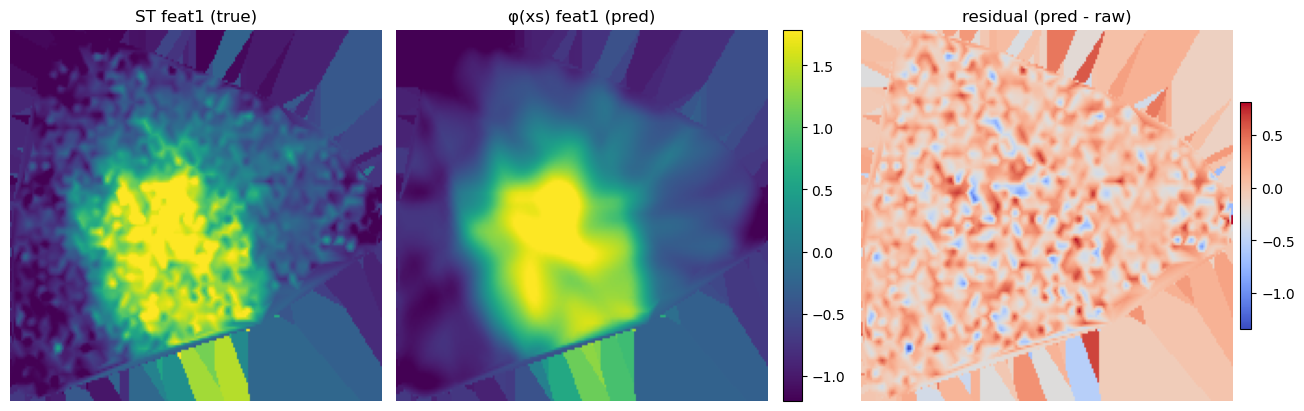

φ feat 1 {'mse': np.float64(0.08619744071221659), 'r2': np.float64(0.9137598220555365), 'corr': np.float64(0.9559329597417386)}


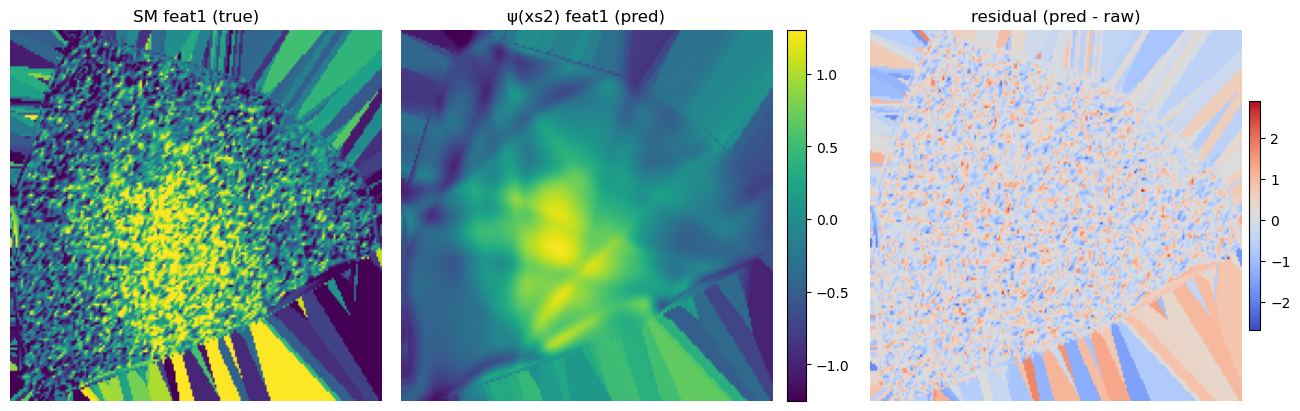

ψ feat 1 {'mse': np.float64(0.7307047870805103), 'r2': np.float64(0.2692265825523943), 'corr': np.float64(0.5191881850822471)}


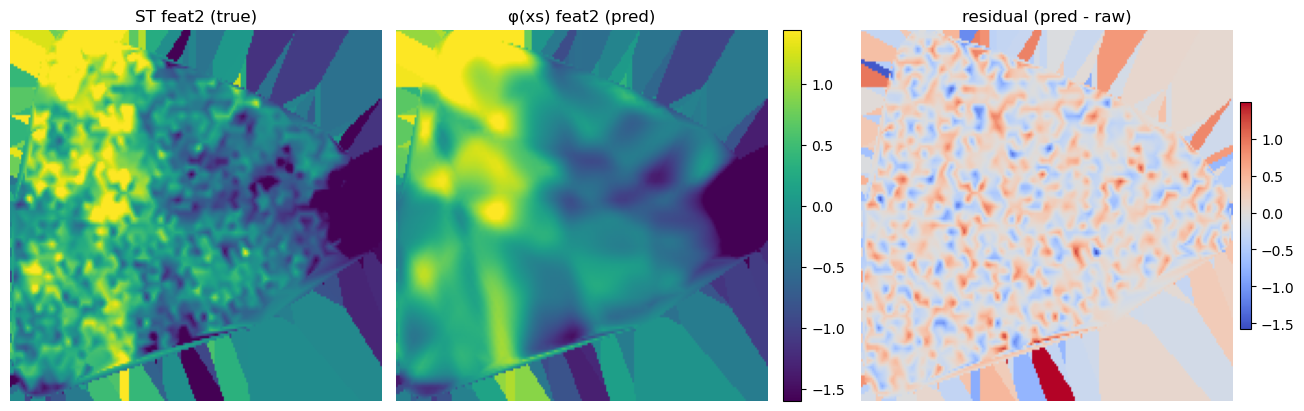

φ feat 2 {'mse': np.float64(0.17233477169560357), 'r2': np.float64(0.8275797834827918), 'corr': np.float64(0.9097780229524999)}


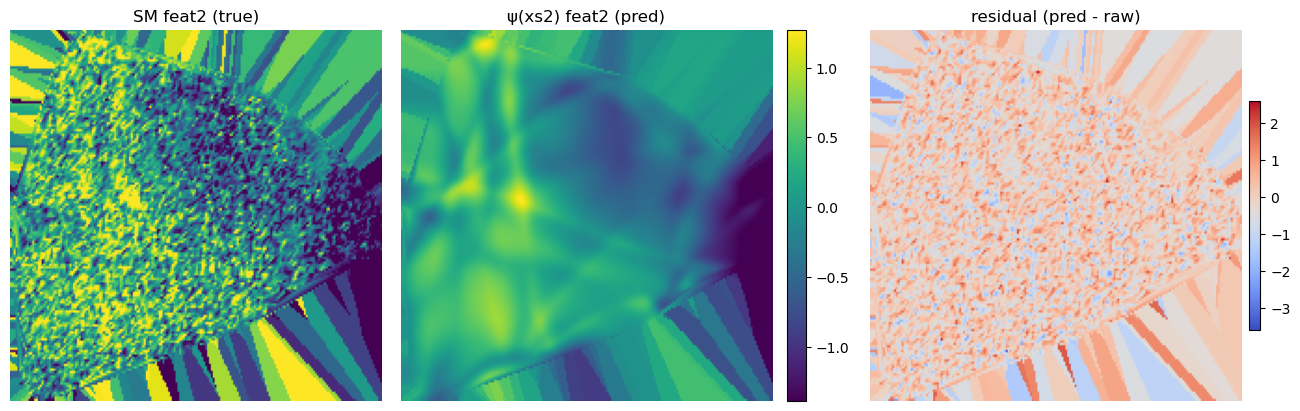

ψ feat 2 {'mse': np.float64(0.7237149507420791), 'r2': np.float64(0.2762170760375324), 'corr': np.float64(0.5256340786399023)}


In [53]:

# quick sanity plots/metrics on a couple random channels
import numpy as np
from mgw.plotting import fit_metrics
rng = np.random.default_rng(0)
for k in rng.choice(dim_f_M, size=min(2, dim_f_M), replace=False):
    X_pred = plotting.predict_on_model(phi, xs)
    plotting.plot_fit_on_cloud(xs, ys_t[:,k].cpu().numpy(), X_pred[:,k],
                               title_true=f'ST feat{k} (true)', title_pred=f'φ(xs) feat{k} (pred)')
    print('φ feat', k, fit_metrics(ys_t[:,k].cpu().numpy(), X_pred[:,k]))
    
    Z_pred = plotting.predict_on_model(psi, xs2)
    plotting.plot_fit_on_cloud(xs2,ys2_t[:,k].cpu().numpy(), Z_pred[:,k],
                               title_true=f'SM feat{k} (true)', title_pred=f'ψ(xs2) feat{k} (pred)')
    print('ψ feat', k, fit_metrics(ys2_t[:,k].cpu().numpy(), Z_pred[:,k]))



Computing metric tensor field
Computed pull-back Jacobian fields
Built kNN graphs
Geodesics computed
[OTT] GW  ε=1.00e-03  iters=-1  loss≈7.3664e-03
Coupling: (2018, 10649) sum: 1.0000075


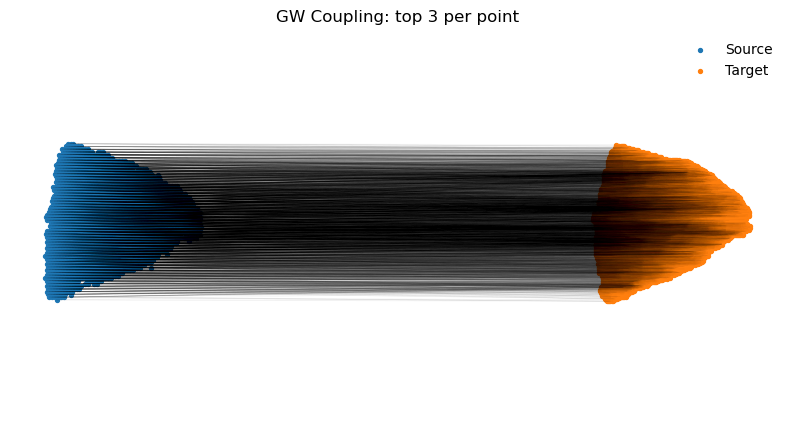

In [54]:
from mgw.gw import solve_gw_ott

# ---------------------------------------
# Pull-back metric tensor fields g^M, g^N
# ---------------------------------------
print('Computing metric tensor field')
G_M = pullback_metric_field(phi, torch.from_numpy(xs).to(device), eps=geodesic_eps).cpu()   # (n,2,2)
G_N = pullback_metric_field(psi, torch.from_numpy(xs2).to(device), eps=geodesic_eps).cpu()   # (m,2,2)
print('Computed pull-back Jacobian fields')

# ----------------------------
# kNN graphs + geodesics
# ----------------------------
G_s = knn_graph(xs,  k=knn_k)
G_t = knn_graph(xs2,  k=knn_k)
print('Built kNN graphs')

D_M = geometry.geodesic_distances_fast(xs,  G_M, G_s)  # (n,n)
D_N = geometry.geodesic_distances_fast(xs2,  G_N, G_t)  # (m,m)
print('Geodesics computed')

def normalize_geodesics(D):
    D = np.maximum(D, 0.0)
    np.fill_diagonal(D, 0.0)
    q = np.quantile(D[np.triu_indices_from(D, k=1)], 0.99)
    return D / (q + 1e-12)

D_Mn = normalize_geodesics(D_M)
D_Nn = normalize_geodesics(D_N)
C_M  = D_Mn**2
C_N  = D_Nn**2

# ----------------------------
# Solve GW on squared geodesic costs
# ----------------------------

gw_params = dict(verbose=True, inner_maxit=2000, outer_maxit=2000,
                 inner_tol=1e-8, outer_tol=1e-8, epsilon=1e-3)

P = solve_gw_ott(C_M, C_N, **gw_params)
print("Coupling:", P.shape, "sum:", P.sum())

# ----------------------------
# Visualize alignment (Procrustes on coordinates)
# ----------------------------

s_aligned, t_aligned, R, tvec = plotting.procrustes_from_coupling(xs, xs2, P)
plotting.plot_alignment_lines_dense(s_aligned, t_aligned, P, alpha=0.05)

In [67]:
from mgw.metrics import Alignment_Clus_Metrics as acm

K=50
Y, Y2 = results["X_pca"], results["Z_pca"]

ami, ari = acm(Y, Y2, P, k=K)

AMI(X,Z) under coupling: 0.21755898867077092
ARI(X,Z) under coupling: 0.05499268916409983


In [68]:
from scipy.spatial.distance import cdist
# Spatial GW baseline
C1_s  = cdist(xs, xs)**2
C2_s  = cdist(xs2, xs2)**2

P_s = solve_gw_ott(C1_s, C2_s, **gw_params)

[OTT] GW  ε=1.00e-03  iters=-1  loss≈2.1197e-03


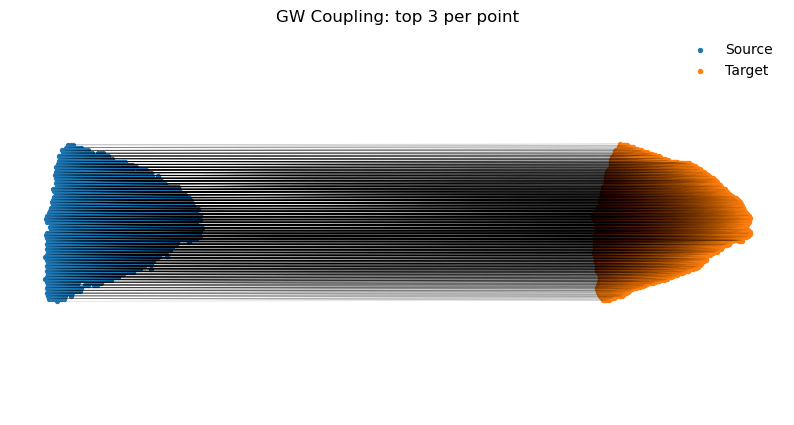

In [72]:
s_aligned, t_aligned, R, tvec = plotting.procrustes_from_coupling(xs, xs2, P_s)
plotting.plot_alignment_lines_dense(s_aligned, t_aligned, P_s, alpha=0.05)

In [69]:
ami, ari = acm(Y, Y2, P_s, k=K)

AMI(X,Z) under coupling: 0.21189849797044571
ARI(X,Z) under coupling: 0.051917651468285024


In [70]:
# SCOT Alignment baseline

C1_f  = cdist(Y, Y)**2
C2_f  = cdist(Y2_ds, Y2_ds)**2

C1_f = C1_f / C1_f.max()
C2_f = C2_f / C2_f.max()

P_f = solve_gw_ott(C1_f, C2_f, **gw_params)


[OTT] GW  ε=1.00e-03  iters=-1  loss≈1.3694e-02


In [71]:
ami, ari = acm(Y, Y2_ds, P_f, k=K)

AMI(X,Z) under coupling: 0.17692068034884992
ARI(X,Z) under coupling: 0.036015485808314436


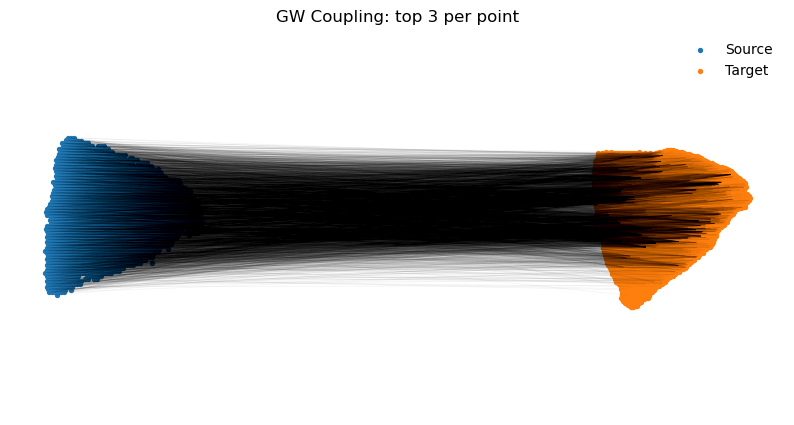

In [60]:
s_aligned, t_aligned, R, tvec = plotting.procrustes_from_coupling(xs, xs2, P_f)
plotting.plot_alignment_lines_dense(s_aligned, t_aligned, P_f, alpha=0.05)